
===テストと成績（シミュレーション用データ）===
   Japanese1  Japanese2       Math  score
0  46.387685  44.253554  47.171367    0.0
1  61.450379  61.205416  62.121120    1.0
2  49.420316  48.201478  39.557640    0.0
3  70.235132  71.750892  45.050707    1.0
4  43.537600  42.067419  42.932289    0.0

===ロジスティック回帰による分類===
accuracy =  0.864
confusion matrix = 
 [[56 13]
 [ 4 52]]
coefficient =  [[-0.06441062  0.16919924  0.0143036 ]]
intercept =  [-5.76899425]

散布図行列


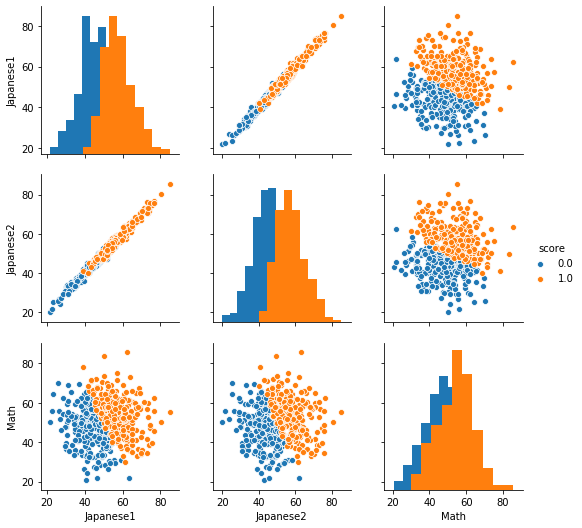


===PCA->ロジスティック回帰による分類===

PCA後の散布図行列


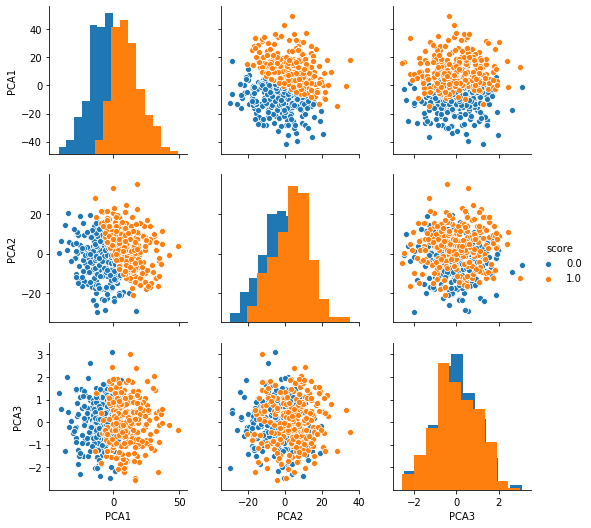


寄与率
[0.66637975 0.33065191 0.00296834]

第3主成分を除外 ロジスティック回帰
accuracy =  1.0
confusion matrix = 
 [[69  0]
 [ 0 56]]
coefficient =  [[4.99597397 3.40544357]]
intercept =  [3.78853398]


In [6]:
from numpy.random import *
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA

# seed fix
np.random.seed(seed=123456)

#----------------------------------------------------------------------
# シミュレーション用データ生成
#----------------------------------------------------------------------
print("\n===テストと成績（シミュレーション用データ）===")
# 多変量正規分布に従う乱数生成 mu=平均, sigma=分散行列
mu = np.array([50, 50, 50])
sigma = np.array( [[1.0, 0.99, 0.0],
                   [0.99, 1.0, 0.0],
                   [0.0, 0.0, 1.0]]) #相関が高くになるように対称となる部分をほぼ同じにする
#sigma = np.identity(3) #ここで単位行列するか否か
sigma = sigma*100
dim = sigma.shape[0]
x_mr = multivariate_normal(mu, sigma, 500)

# ある区間で分ける=scoreとしよう
x_mr = np.insert(x_mr, dim, 0, axis=1)
for i in x_mr:
    sum = np.sum(i)
    if sum < 150:
        i[3] = 0
    else:
        i[3] = 1

data=pd.DataFrame(x_mr)
data.columns = ['Japanese1', 'Japanese2', 'Math', 'score']
print(data.head())

#----------------------------------------------------------------------
# ロジスティック回帰
#----------------------------------------------------------------------
print("\n===ロジスティック回帰による分類===")

# データを分割
y = data['score']
X = data.drop('score', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) #学習用と推測用を分ける

# ロジスティック回帰
# 勾配法で正則化無しで求める
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(penalty='none', solver="sag", max_iter=5000, random_state=1)
#clf = LogisticRegression(C=10, penalty='l2', solver="sag", max_iter=5000) #L2ノルム正則化
#clf = LogisticRegression(C=0.1, penalty='l1', solver="liblinear", max_iter=5000) #L1ノルム 縮小選択
clf.fit(X_train, y_train)
X_test_result = clf.predict(X_test)
# print(clf.get_params()) 

# 結果を出力
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=X_test_result))
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=X_test_result))
print("coefficient = ", clf.coef_)
print("intercept = ", clf.intercept_)

print("\n散布図行列")
grid = sns.pairplot(data, 
                    vars=['Japanese1', 'Japanese2', 'Math'],
                    diag_kind='hist', hue='score')
plt.show(grid)
grid.savefig("pairplot.png", dpi=200)

#----------------------------------------------------------------------
# PCA->ロジスティック回帰
#----------------------------------------------------------------------
print("\n===PCA->ロジスティック回帰による分類===")
# PCA
# 上位の成分だけ使うという目的でsklearnを使用
pca = PCA()
feature = pca.fit_transform(X)
dim = feature.shape[1]
feature = np.insert(feature, dim, y.values, axis=1)
df_feature=pd.DataFrame(feature)
df_feature.columns = ['PCA1', 'PCA2', 'PCA3', 'score']

print("\nPCA後の散布図行列")
grid = sns.pairplot(df_feature, 
                    vars=['PCA1', 'PCA2', 'PCA3'],
                    diag_kind='hist', hue='score')
plt.show(grid)
grid.savefig("pca_pairplot_pca.png", dpi=200)

print("\n寄与率")
print(pca.explained_variance_ratio_)

# PCA後でロジスティック回帰
print("\n第3主成分を除外 ロジスティック回帰")
y1 = df_feature['score']
X1 = df_feature.drop(['PCA3','score'], axis = 1) #第3主成分を除外
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1)

clf = LogisticRegression(penalty='none', solver="sag", max_iter=5000, random_state=1)
clf.fit(X1_train, y1_train)
X1_test_result = clf.predict(X1_test)

# 結果を出力
print('accuracy = ', accuracy_score(y_true=y1_test, y_pred=X1_test_result))
print('confusion matrix = \n', confusion_matrix(y_true=y1_test, y_pred=X1_test_result))
print("coefficient = ", clf.coef_)
print("intercept = ", clf.intercept_)